In [28]:
from sklearn.datasets import fetch_openml
import random
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import f1_score
import pandas as pd

In [4]:
mnist = fetch_openml("mnist_784", data_home="data/mnist_784", cache=True)

In [9]:
zipped_mnist = list(zip(mnist.data, mnist.target))
mnist_random = random.sample(zipped_mnist, 10000)
x, y = zip(*(mnist_random))
x = np.asarray(x)
y = np.asarray(y)

In [11]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(30)
x_pca = pca.fit_transform(x_scaled)

In [14]:
x_embedded = TSNE(n_components=2).fit_transform(x_pca)

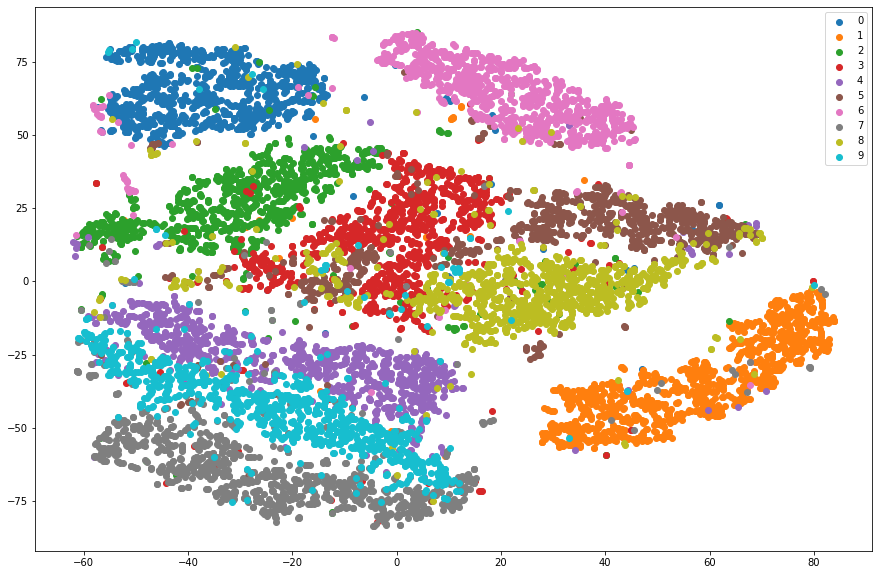

In [18]:
plt.figure(figsize=(15,10))

for c, ids in zip(mcolors.TABLEAU_COLORS, [str(i) for i in range(10)]):
    plt.scatter(x_embedded[y == ids, 0], x_embedded[y == ids, 1], c=c, label=ids)
plt.legend()
plt.show()

In [19]:
# wybrano 3 i 8
digit_filter = np.where((y == '3') | (y == '8'))
x_filtered, y_filtered = x_pca[digit_filter], y[digit_filter]

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_filtered, y_filtered, train_size=0.8)
x_train.shape

(1605, 30)

In [25]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, max_samples=0.4)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9676616915422885

In [39]:
estimators = range(5, 105, 10)
samples = np.linspace(0.1, 1.0, num=10)

results = pd.DataFrame()
# results_f1 = pd.DataFrame()

for n_estimators in estimators:
    for max_samples in samples:
        clf = BaggingClassifier(base_estimator=SVC(), n_estimators=n_estimators, max_samples=max_samples)
        clf.fit(x_train, y_train)
#         pred = clf.predict(x_test)
        results.at[n_estimators, max_samples] = clf.score(x_test, y_test)
#         results_f1.at[n_estimators, max_samples] = f1_score(y_test, pred, average='weighted')
        
results

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
5,0.957711,0.960199,0.962687,0.967662,0.972637,0.965174,0.970149,0.965174,0.972637,0.965174
15,0.955224,0.967662,0.965174,0.972637,0.972637,0.970149,0.972637,0.972637,0.970149,0.975124
25,0.960199,0.960199,0.970149,0.975124,0.975124,0.967662,0.977612,0.970149,0.972637,0.972637
35,0.952736,0.965174,0.960199,0.972637,0.970149,0.967662,0.970149,0.970149,0.975124,0.975124
45,0.947761,0.960199,0.962687,0.967662,0.967662,0.970149,0.970149,0.967662,0.970149,0.975124
55,0.950249,0.962687,0.965174,0.960199,0.970149,0.967662,0.967662,0.972637,0.972637,0.972637
65,0.960199,0.962687,0.960199,0.965174,0.970149,0.975124,0.970149,0.975124,0.972637,0.972637
75,0.952736,0.962687,0.965174,0.962687,0.967662,0.972637,0.970149,0.970149,0.972637,0.970149
85,0.957711,0.965174,0.957711,0.962687,0.965174,0.970149,0.972637,0.972637,0.972637,0.970149
95,0.952736,0.965174,0.965174,0.967662,0.970149,0.972637,0.970149,0.970149,0.972637,0.972637
